# Udacity Capstone Project
## Starbucks Promotional Offers
### April 2023

# Data Sets
The data for this project are contained in three files:

- **portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
- **profile.json** - demographic data for each customer
- **transcript.json** - records for transactions, offers received, offers viewed, and offers completed

## Schema details
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - monetary reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle_data import clean_portfolio, clean_profile, clean_transcript, merge_data, age_bins, income_bins, extract_offer_id, extract_amount
from recommendations import create_ranked_offers, popular_recommendations, create_user_item_matrix
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### portfolio.json

In [3]:
# look at first few rows
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# shape of portfolio data
print('Number of portfolio data rows: {}'.format(portfolio.shape[0]))
print('Number of portfolio data columns: {}'.format(portfolio.shape[1]))

Number of portfolio data rows: 10
Number of portfolio data columns: 6


In [5]:
# column information
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
# any missing values
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
# summary stats
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0


In [8]:
# how many unique offer ids
print('Unique offer ids: {}'.format(portfolio.id.nunique()))

Unique offer ids: 10


In [9]:
# distribution of offer ids
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [10]:
# distribution of offer durations
portfolio.duration.value_counts()

7     4
5     2
10    2
4     1
3     1
Name: duration, dtype: int64

### profile.json

In [11]:
# look at first few rows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# shape of profile data
print('Number of profile data rows: {}'.format(profile.shape[0]))
print('Number of profile data columns: {}'.format(profile.shape[1]))

Number of profile data rows: 17000
Number of profile data columns: 5


In [13]:
# column information
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
# any missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
# summary stats
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


In [16]:
profile.loc[profile['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### transcript.json

In [18]:
# look at first few rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
# shape of transcript data
print('Number of transcript data rows: {}'.format(transcript.shape[0]))
print('Number of transcript data columns: {}'.format(transcript.shape[1]))

Number of transcript data rows: 306534
Number of transcript data columns: 4


In [20]:
# column information
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
# any missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [22]:
# what are the unique events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [23]:
# what are the event counts
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
# what does a transaction value look like
transcript.query('event == "transaction"')['value'].iloc[0]

{'amount': 0.8300000000000001}

In [25]:
# what does a offer received value look like
transcript.query('event == "offer received"')['value'].iloc[0]

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [26]:
# what does a offer viewed value look like
transcript.query('event == "offer viewed"')['value'].iloc[0]

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

In [27]:
# what does a offer completed value look like
transcript.query('event == "offer completed"')['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

### Data Observations
#### portfolio.json
- channels can be one-hot encoded
- offer_type can be one-hot encoded
- id column is offer_id
- there are no missing values

#### profile.json 
- id in this data set is a customer id
- gender and income each have 2175 missing values. 
- maximum age is 118, which appears out of line. 
- age = 118 is in the same 2175 records with missing gender and income.
- became_member_on is a data field, but represented as integer

#### transcript.json 
- time column represents hours since start of test, but is integer format
- people column is equivalent to customer id in profile dataset

## Data Cleaning

#### portfolio dataframe
- rename "id" column to "offer_id"
- rename "duration" column to "days_open"
- rename "difficulty" column to "min_spend"
- one-hot encode "channels" column
- one-hot encode "offer_type" column
- drop "channels" and "offer_type" columns after one-hot encoding

In [28]:
# call clean_portfolio function to clean the portfolio dataset
portfolio_clean = clean_portfolio()
portfolio_clean

,offer_id,reward,min_spend,days_open,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,0,1,0,1,0


#### profile dataframe
- rename "id" column to "customer_id"
- remove the 2175 rows where "gender" and "income" have missing values and "age" equals 118
- one-hot encode 'gender' column
- convert "became_member_on" to datetime and label "membership_start"
- create "membership_year" from "membership_start"
- reorder columns

In [29]:
# call clean_profile to clean profile data
profile_clean = clean_profile()
profile_clean.head()

,customer_id,age,income,female,male,membership_start,membership_year
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,2017-07-15,2017
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,2017-05-09,2017
5,e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,2018-04-26,2018
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,2018-02-09,2018
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,2017-11-11,2017


#### transcript dataframe
- rename 'person' column to 'customer_id'
- one-hot encode 'event' column
- split transcript dataframe into transaction and offers dataframes
- extract 'offer_id' from 'value' column
- extract 'transaction' from 'value' column
- drop unneeded columns

In [30]:
# call clean_transcript to clean transcript data
transcript_clean = clean_transcript()

In [31]:
transcript_clean.head(2)

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,NaN,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,1,0,NaN,0


In [32]:
# call merge_data to merge cleaned data sets and write out offers and transactions csv files 
merge_data(portfolio_clean, profile_clean, transcript_clean)

In [33]:
# read in cleaned data and display first couple of rows
combined_df = pd.read_csv('data/starbucks_combined_data.csv')
combined_df.head(2)

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,web,bogo,discount,informational,age,income,female,male,membership_start,membership_year
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,1.0,1.0,0.0,0.0,75.0,100000.0,1.0,0.0,2017-05-09,2017.0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration and Analysis

For comparison, it may be useful to have 'age' and 'income' ranges.

In [34]:
# 'age' summary stats - offers dataset
combined_df['age'].describe().T

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [35]:
# 'income' summary stats - offers dataset
combined_df['income'].describe().T

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

In [36]:
# create age bins in offers dataset
combined_df = age_bins(combined_df)
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,female,male,membership_start,membership_year,18-29,30-44,45-59,60-74,75-89,90-101
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,1.0,0.0,2017-05-09,2017.0,0,0,0,0,1,0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,0.0,1.0,2018-04-26,2018.0,0,0,0,1,0,0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [37]:
# create income bins in offers dataset
combined_df = income_bins(combined_df)
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,30-44,45-59,60-74,75-89,90-101,30k-49k,50k-69k,70k-89k,90k-109k,110k-120k
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,0,0,0,1,0,0,0,0,1,0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,0,0,0,0,0,0,0,0,0,0
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,0,0,1,0,0,0,0,1,0,0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,0,0,0,0,0,0,0,0,0,0


### Look at some simple frequency distributions

In [38]:
# create age and income dictionaries
age_cols = ['18-29', '30-44', '45-59', '60-74', '75-89', '90-101']
income_cols = ['30k-49k', '50k-69k', '70k-89k', '90k-109k', '110k-120k']

In [39]:
# age distribution in offers
age_dist = combined_df[combined_df['offer_completed'] == 1][age_cols].sum()
age_dist

18-29      2577
30-44      5126
45-59     11014
60-74      9351
75-89      3618
90-101      629
dtype: int64

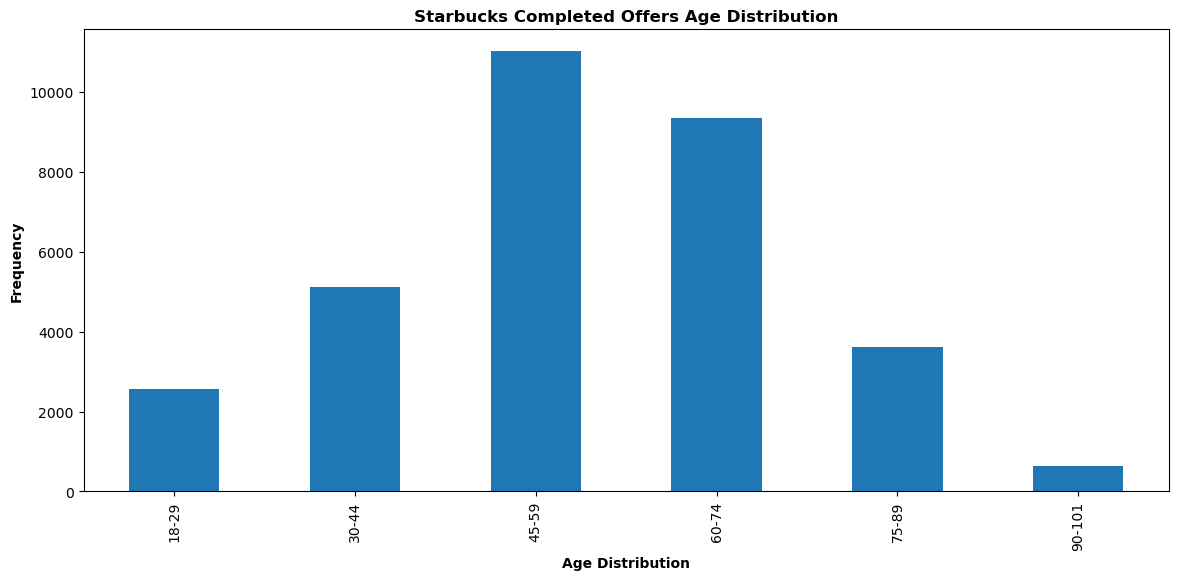

In [40]:
# plot offers age distribution
plt.figure(figsize = (14, 6))
age_dist.plot(kind = 'bar')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Age Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 45-years to 74-years age group.

In [41]:
# income distribution in offers
income_dist = combined_df[combined_df['offer_completed'] == 1][income_cols].sum()
income_dist

30k-49k       5943
50k-69k      10521
70k-89k       9535
90k-109k      4865
110k-120k     1460
dtype: int64

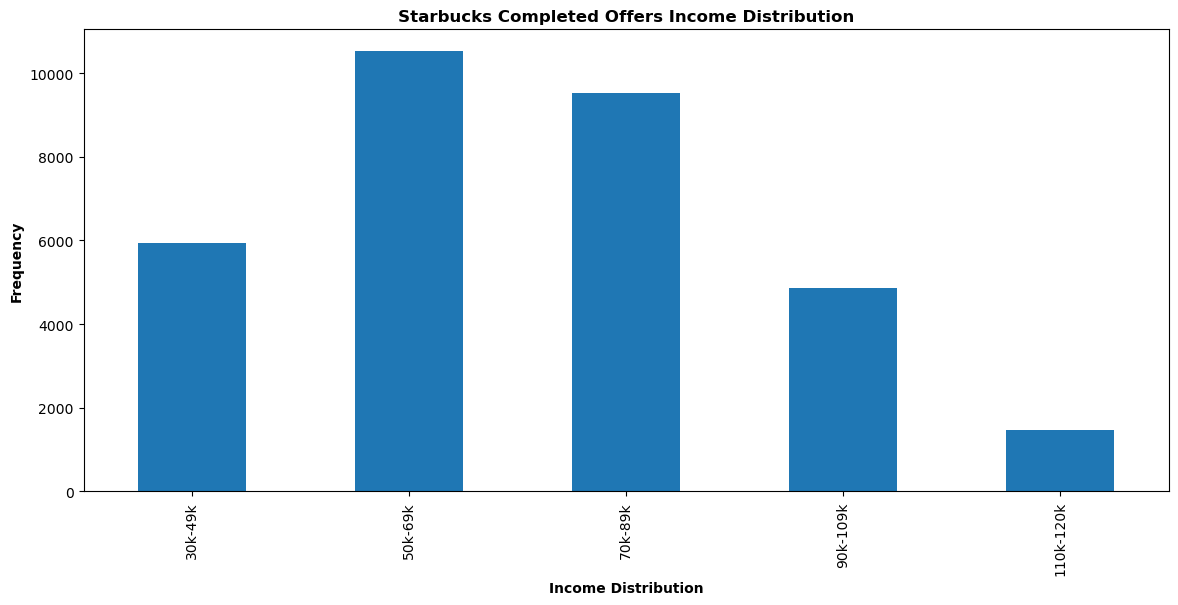

In [42]:
# plot offers income distribution
plt.figure(figsize = (14, 6))
income_dist.plot(kind = 'bar')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Income Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 50,000 - 89,000 income range.

In [43]:
# offer type distribution in offers
offer_type_cols = ['bogo', 'discount']
offer_type_dist = combined_df[combined_df['offer_completed'] == 1][offer_type_cols].sum()
offer_type_dist

bogo        15669.0
discount    17910.0
dtype: float64

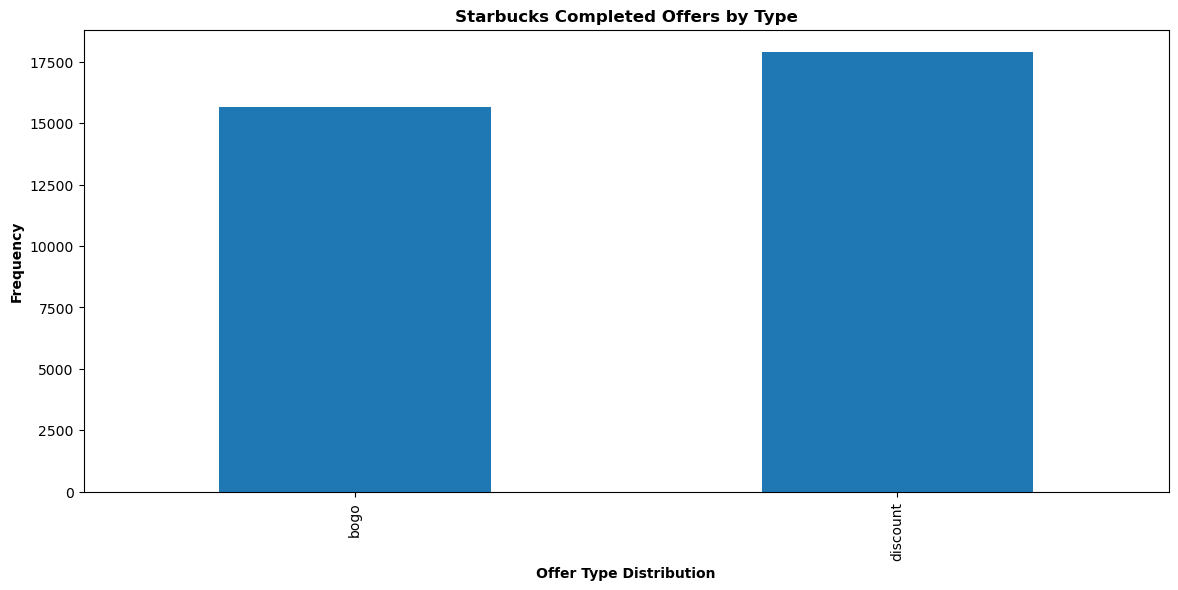

In [44]:
# plot offer type distribution
plt.figure(figsize = (14, 6))
offer_type_dist.plot(kind = 'bar')
plt.xlabel('Offer Type Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Type', weight = 'bold');

> Discount offers are slightly more prevelant than bogo.

In [45]:
channels_cols = ['email', 'mobile', 'social', 'web']
offer_channels_dist = combined_df[combined_df['offer_completed'] == 1][channels_cols].sum()
offer_channels_dist

email     33579.0
mobile    30159.0
social    21788.0
web       29891.0
dtype: float64

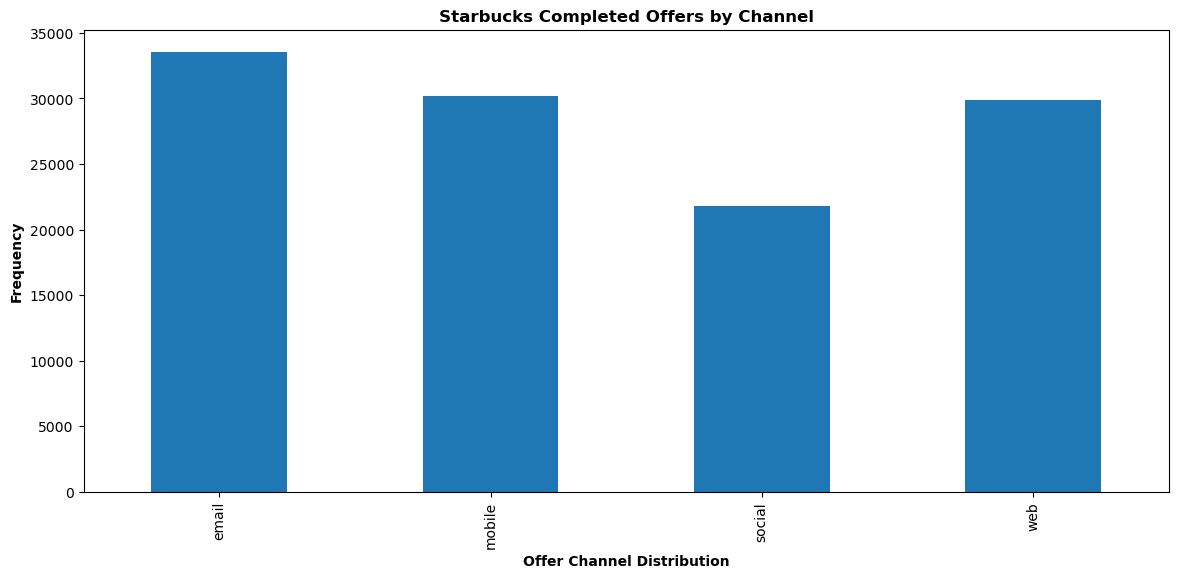

In [46]:
# plot offer channel distribution
plt.figure(figsize = (14, 6))
offer_channels_dist.plot(kind = 'bar')
plt.xlabel('Offer Channel Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Channel', weight = 'bold');

> Email channel frequency is slightly higher than mobile and web.

In [47]:
# offer type distribution in offers
gender_cols = ['male', 'female']
gender_dist = combined_df[combined_df['offer_completed'] == 1][gender_cols].sum()
gender_dist

male      16466.0
female    15477.0
dtype: float64

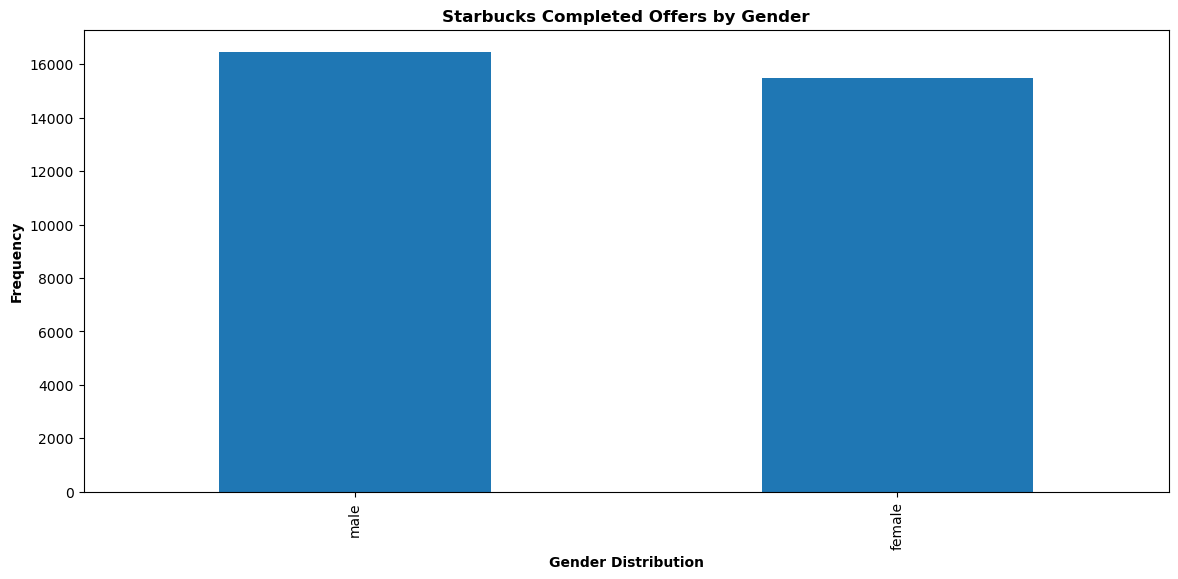

In [48]:
# plot gender distribution
plt.figure(figsize = (14, 6))
gender_dist.plot(kind = 'bar')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Gender', weight = 'bold');

> Slightly higher number of completed offers for male customers.

In [49]:
# age distribution of transaction data
t_age_dist = combined_df[combined_df['amount'] > 0][age_cols].sum()
t_age_dist

18-29     15528
30-44     24294
45-59     37873
60-74     31511
75-89     12022
90-101     2030
dtype: int64

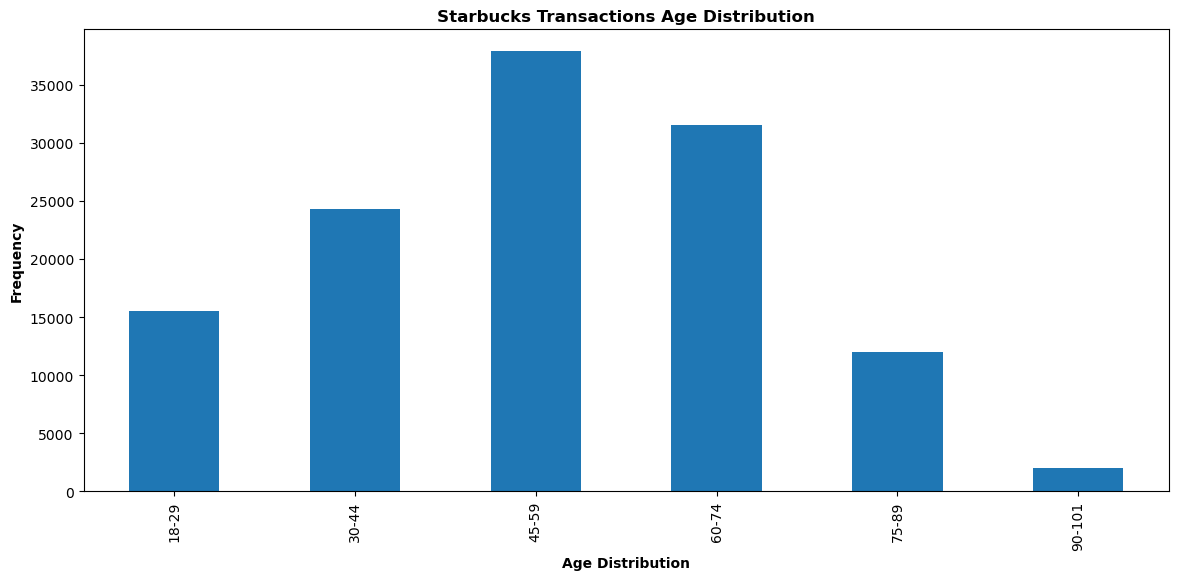

In [50]:
# plot transaction age distribution
plt.figure(figsize = (14, 6))
t_age_dist.plot(kind = 'bar')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Age Distribution', weight = 'bold');

> Similar to the completed offers data, the bulk of transaction data is in the 45-years to 74-years age groups.

In [51]:
# income distribution of transaction data
t_income_dist = combined_df[combined_df['amount'] > 0][income_cols].sum()
t_income_dist

30k-49k      37075
50k-69k      45035
70k-89k      26610
90k-109k     11178
110k-120k     3185
dtype: int64

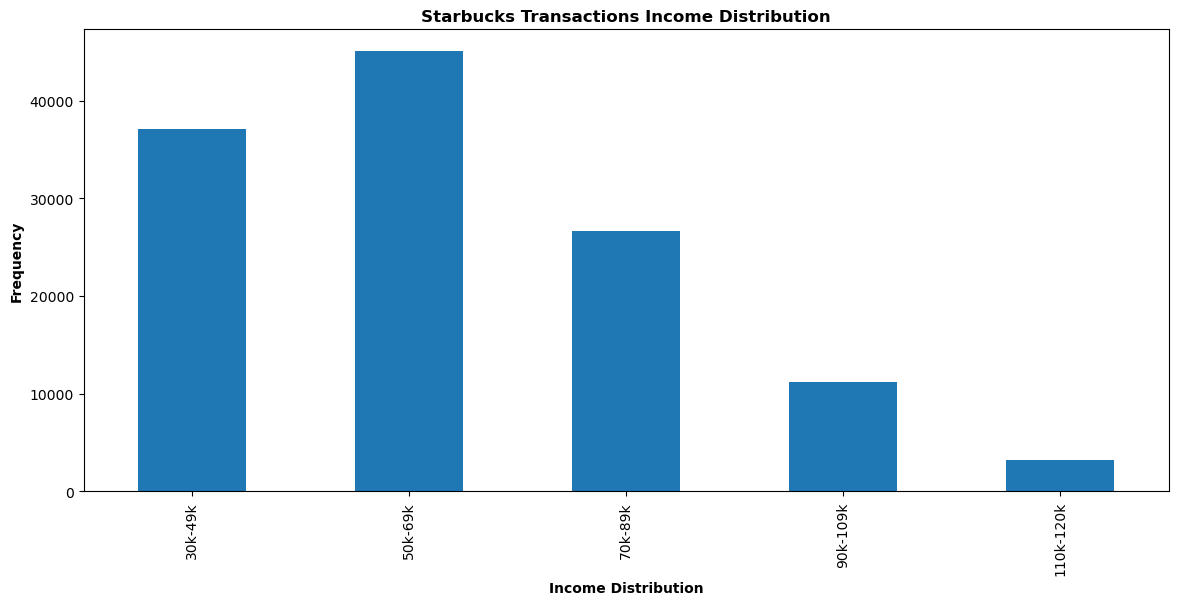

In [52]:
# plot transaction income distribution
plt.figure(figsize = (14, 6))
t_income_dist.plot(kind = 'bar')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Income Distribution', weight = 'bold');

> Income distribution is shifted lower with the transaction data, with the bulk in the 30,000 to 69,000 range.

In [53]:
# income distribution of transaction data
t_gender_dist = combined_df[combined_df['amount'] > 0][gender_cols].sum()
t_gender_dist

male      72794.0
female    49382.0
dtype: float64

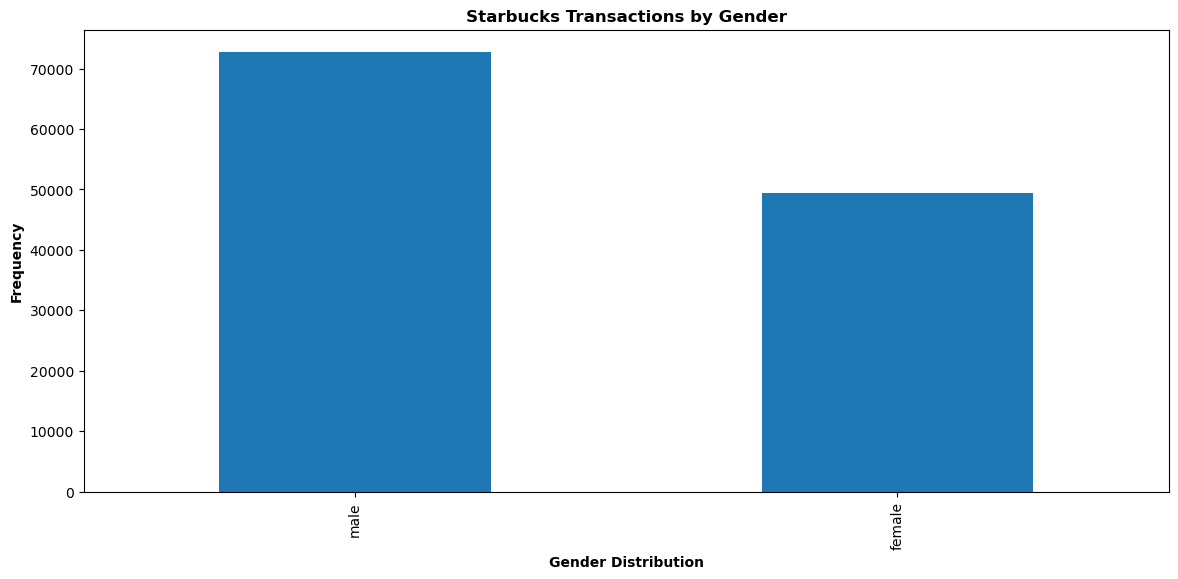

In [54]:
# plot gender distribution
plt.figure(figsize = (14, 6))
t_gender_dist.plot(kind = 'bar')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions by Gender', weight = 'bold');

> Transactions for males are significantly higher.

In [55]:
# which customers are the big spenders
top_amounts = combined_df.groupby('customer_id')['amount'].sum().nlargest(10)
top_amounts

customer_id
4029     1608.69
16081    1365.66
11703    1327.74
6519     1321.42
7673     1319.97
5494     1292.86
11615    1258.19
14016    1251.99
9913     1232.40
6640     1211.76
Name: amount, dtype: float64

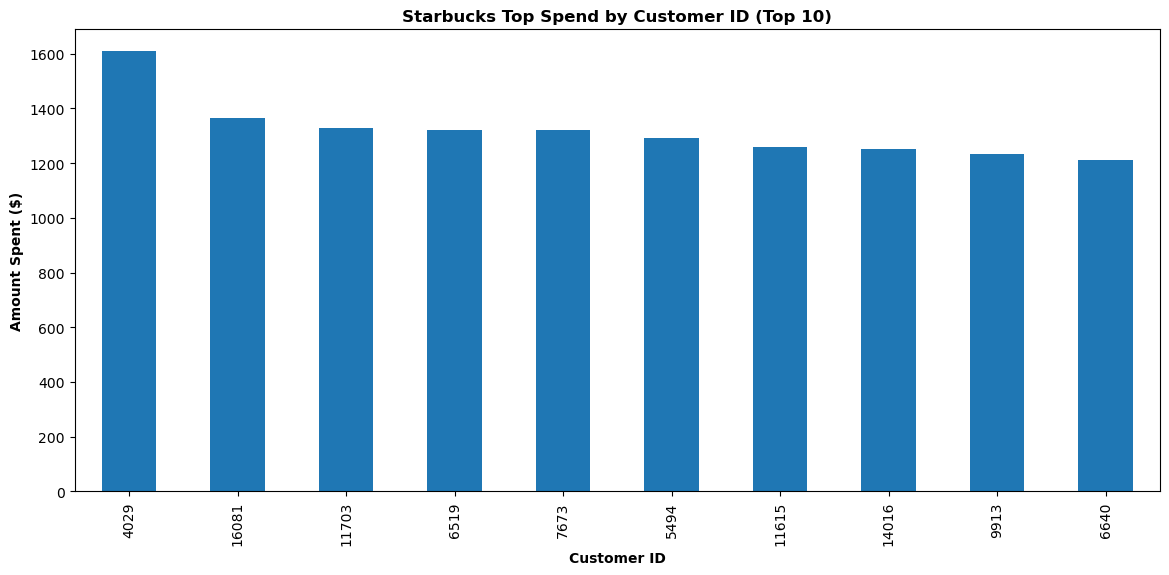

In [56]:
# plot gender distribution
plt.figure(figsize = (14, 6))
top_amounts.plot(kind = 'bar')
plt.xlabel('Customer ID', weight = 'bold')
plt.ylabel('Amount Spent ($)', weight = 'bold')
plt.title('Starbucks Top Spend by Customer ID (Top 10)', weight = 'bold');

> Customer ID 4029 has spent more than 200 dollars above the nearest customer ID.

## Recommendations

In [57]:
# determine top ranked offers based on offers_completed vs. offers_received
ranked_completed = create_ranked_offers(combined_df)
ranked_completed

,offer_id,offer_viewed,offer_completed,completion_ratio
0,0,2663,3420,1.284266
6,6,4171,4354,1.043874
2,2,4118,4017,0.975474
9,9,7327,5317,0.725672
1,1,7337,5156,0.702740
8,8,7264,4296,0.591410
7,7,6716,3688,0.549136
4,4,7298,3331,0.456426
3,3,4144,0,0.000000
5,5,6687,0,0.000000


In [58]:
# get the 5 most popular offer_id's
recs_5 = popular_recommendations(ranked_completed, 5)
recs_5

The top  5  offer recommendations: 


[0, 6, 2, 9, 1]

In [71]:
# create the user item matrix
user_item = create_user_item_matrix(combined_df)
user_item.head()

offer_id,0,1,2,3,4,5,6,7,8,9,10
customer_id,,,,,,,,,,,
0,0,0,1,1,0,1,0,0,1,1,1
1,0,0,0,0,0,0,0,0,1,0,1
2,1,1,0,1,0,1,1,0,0,0,1
3,0,0,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,1,0,1


In [72]:
user_item.shape[0]

17000

In [73]:
def offers_completed(customer_id):
    '''
    INPUT:
        customer_id - the customer_id of an individual as int
    OUTPUT:
        offers - an array of offers the user has seen
    '''
    offers = user_item.loc[customer_id][user_item.loc[customer_id].isnull() == False].index.values

    return offers

In [74]:
def create_user_offer_dict():
    '''
    INPUT: 
        None
    OUTPUT: 
        offers_seen - a dictionary where each key is a customer_id and the value is an array of offer_ids
    
    Creates the offers_seen dictionary
    '''
    n_users = user_item.shape[0]
    offers_seen = dict()

    for user in range(1, n_users-1):
        
        # assign list of movies to each user key
        offers_seen[user] = offers_completed(user)
        
    return offers_seen

In [75]:
offers_completed(16999)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [76]:
offers_seen = create_user_offer_dict()

In [77]:
def create_offers_to_analyze(offers_seen, lower_bound=2):
    '''
    INPUT:  
        offers_seen - a dictionary where each key is a customer_id and the value is an array of offer_ids
        lower_bound - (an int) a user must have more movies seen than the lower bound to be added to the movies_to_analyze dictionary

    OUTPUT: 
    offers_to_analyze - a dictionary where each key is a customer_id and the value is an array of offer_ids
    
    The offers_seen and offers_to_analyze dictionaries should be the same except that the output dictionary has removed 
    
    '''
    offers_to_analyze = dict()

    for user, offers in offers_seen.items():
        print(user, offers)
        if len(offers) > lower_bound:
            offers_to_analyze[user] = offers
    return offers_to_analyze



In [78]:
offers_to_analyze = create_offers_to_analyze(offers_seen)

1 [ 0  1  2  3  4  5  6  7  8  9 10]
2 [ 0  1  2  3  4  5  6  7  8  9 10]
3 [ 0  1  2  3  4  5  6  7  8  9 10]
4 [ 0  1  2  3  4  5  6  7  8  9 10]
5 [ 0  1  2  3  4  5  6  7  8  9 10]
6 [ 0  1  2  3  4  5  6  7  8  9 10]
7 [ 0  1  2  3  4  5  6  7  8  9 10]
8 [ 0  1  2  3  4  5  6  7  8  9 10]
9 [ 0  1  2  3  4  5  6  7  8  9 10]
10 [ 0  1  2  3  4  5  6  7  8  9 10]
11 [ 0  1  2  3  4  5  6  7  8  9 10]
12 [ 0  1  2  3  4  5  6  7  8  9 10]
13 [ 0  1  2  3  4  5  6  7  8  9 10]
14 [ 0  1  2  3  4  5  6  7  8  9 10]
15 [ 0  1  2  3  4  5  6  7  8  9 10]
16 [ 0  1  2  3  4  5  6  7  8  9 10]
17 [ 0  1  2  3  4  5  6  7  8  9 10]
18 [ 0  1  2  3  4  5  6  7  8  9 10]
19 [ 0  1  2  3  4  5  6  7  8  9 10]
20 [ 0  1  2  3  4  5  6  7  8  9 10]
21 [ 0  1  2  3  4  5  6  7  8  9 10]
22 [ 0  1  2  3  4  5  6  7  8  9 10]
23 [ 0  1  2  3  4  5  6  7  8  9 10]
24 [ 0  1  2  3  4  5  6  7  8  9 10]
25 [ 0  1  2  3  4  5  6  7  8  9 10]
26 [ 0  1  2  3  4  5  6  7  8  9 10]
27 [ 0  1  2  3  4  5

6788 [ 0  1  2  3  4  5  6  7  8  9 10]
6789 [ 0  1  2  3  4  5  6  7  8  9 10]
6790 [ 0  1  2  3  4  5  6  7  8  9 10]
6791 [ 0  1  2  3  4  5  6  7  8  9 10]
6792 [ 0  1  2  3  4  5  6  7  8  9 10]
6793 [ 0  1  2  3  4  5  6  7  8  9 10]
6794 [ 0  1  2  3  4  5  6  7  8  9 10]
6795 [ 0  1  2  3  4  5  6  7  8  9 10]
6796 [ 0  1  2  3  4  5  6  7  8  9 10]
6797 [ 0  1  2  3  4  5  6  7  8  9 10]
6798 [ 0  1  2  3  4  5  6  7  8  9 10]
6799 [ 0  1  2  3  4  5  6  7  8  9 10]
6800 [ 0  1  2  3  4  5  6  7  8  9 10]
6801 [ 0  1  2  3  4  5  6  7  8  9 10]
6802 [ 0  1  2  3  4  5  6  7  8  9 10]
6803 [ 0  1  2  3  4  5  6  7  8  9 10]
6804 [ 0  1  2  3  4  5  6  7  8  9 10]
6805 [ 0  1  2  3  4  5  6  7  8  9 10]
6806 [ 0  1  2  3  4  5  6  7  8  9 10]
6807 [ 0  1  2  3  4  5  6  7  8  9 10]
6808 [ 0  1  2  3  4  5  6  7  8  9 10]
6809 [ 0  1  2  3  4  5  6  7  8  9 10]
6810 [ 0  1  2  3  4  5  6  7  8  9 10]
6811 [ 0  1  2  3  4  5  6  7  8  9 10]
6812 [ 0  1  2  3  4  5  6  7  8  9 10]


11715 [ 0  1  2  3  4  5  6  7  8  9 10]
11716 [ 0  1  2  3  4  5  6  7  8  9 10]
11717 [ 0  1  2  3  4  5  6  7  8  9 10]
11718 [ 0  1  2  3  4  5  6  7  8  9 10]
11719 [ 0  1  2  3  4  5  6  7  8  9 10]
11720 [ 0  1  2  3  4  5  6  7  8  9 10]
11721 [ 0  1  2  3  4  5  6  7  8  9 10]
11722 [ 0  1  2  3  4  5  6  7  8  9 10]
11723 [ 0  1  2  3  4  5  6  7  8  9 10]
11724 [ 0  1  2  3  4  5  6  7  8  9 10]
11725 [ 0  1  2  3  4  5  6  7  8  9 10]
11726 [ 0  1  2  3  4  5  6  7  8  9 10]
11727 [ 0  1  2  3  4  5  6  7  8  9 10]
11728 [ 0  1  2  3  4  5  6  7  8  9 10]
11729 [ 0  1  2  3  4  5  6  7  8  9 10]
11730 [ 0  1  2  3  4  5  6  7  8  9 10]
11731 [ 0  1  2  3  4  5  6  7  8  9 10]
11732 [ 0  1  2  3  4  5  6  7  8  9 10]
11733 [ 0  1  2  3  4  5  6  7  8  9 10]
11734 [ 0  1  2  3  4  5  6  7  8  9 10]
11735 [ 0  1  2  3  4  5  6  7  8  9 10]
11736 [ 0  1  2  3  4  5  6  7  8  9 10]
11737 [ 0  1  2  3  4  5  6  7  8  9 10]
11738 [ 0  1  2  3  4  5  6  7  8  9 10]
11739 [ 0  1  2 

16387 [ 0  1  2  3  4  5  6  7  8  9 10]
16388 [ 0  1  2  3  4  5  6  7  8  9 10]
16389 [ 0  1  2  3  4  5  6  7  8  9 10]
16390 [ 0  1  2  3  4  5  6  7  8  9 10]
16391 [ 0  1  2  3  4  5  6  7  8  9 10]
16392 [ 0  1  2  3  4  5  6  7  8  9 10]
16393 [ 0  1  2  3  4  5  6  7  8  9 10]
16394 [ 0  1  2  3  4  5  6  7  8  9 10]
16395 [ 0  1  2  3  4  5  6  7  8  9 10]
16396 [ 0  1  2  3  4  5  6  7  8  9 10]
16397 [ 0  1  2  3  4  5  6  7  8  9 10]
16398 [ 0  1  2  3  4  5  6  7  8  9 10]
16399 [ 0  1  2  3  4  5  6  7  8  9 10]
16400 [ 0  1  2  3  4  5  6  7  8  9 10]
16401 [ 0  1  2  3  4  5  6  7  8  9 10]
16402 [ 0  1  2  3  4  5  6  7  8  9 10]
16403 [ 0  1  2  3  4  5  6  7  8  9 10]
16404 [ 0  1  2  3  4  5  6  7  8  9 10]
16405 [ 0  1  2  3  4  5  6  7  8  9 10]
16406 [ 0  1  2  3  4  5  6  7  8  9 10]
16407 [ 0  1  2  3  4  5  6  7  8  9 10]
16408 [ 0  1  2  3  4  5  6  7  8  9 10]
16409 [ 0  1  2  3  4  5  6  7  8  9 10]
16410 [ 0  1  2  3  4  5  6  7  8  9 10]
16411 [ 0  1  2 

In [79]:
def compute_correlation(user1, user2):
    '''
    INPUT
        user1 - int customer_id
        user2 - int customer_id
    OUTPUT
        corr - the correlation between the matching offers between the two users
    '''
    # Pull offers for each user
    offers1 = offers_to_analyze[user1]
    offers2 = offers_to_analyze[user2]
    
    
    # Find Similar Offers
    sim_offers = np.intersect1d(offers1, offers2, assume_unique=True)
    
    # Calculate correlation between the users
    df = user_item.loc[(user1, user2), sim_offers]
    corr = df.transpose().corr().iloc[0,1]
    
    return corr #return the correlation

In [90]:
compute_correlation(130, 340)

0.6333333333333334

In [81]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
        user1 - int customer_id
        user2 - int customer_id
    OUTPUT
        dist - the euclidean distance between user1 and user2
    '''
    # Pull offers for each user
    offers1 = offers_to_analyze[user1]
    offers2 = offers_to_analyze[user2]
    
    
    # Find Similar Offers
    sim_offers = np.intersect1d(offers1, offers2, assume_unique=True)
    
    # Calculate euclidean distance between the users
    df = user_item.loc[(user1, user2), sim_offers]
    dist = np.linalg.norm(df.loc[user1] - df.loc[user2])
    
    return dist #return the euclidean distance

In [89]:
print('Euclidean distance: ', compute_euclidean_dist(130, 340))

Euclidean distance:  1.4142135623730951


In [83]:
def compute_manhattan_dist(user1, user2):
    '''
    INPUT
        user1 - int customer_id
        user2 - int customer_id
    OUTPUT
        dist - the manhattan distance between user1 and user2
    '''
    from scipy.spatial import distance
    
    # Pull offers for each user
    offers1 = offers_to_analyze[user1]
    offers2 = offers_to_analyze[user2]
    
    
    # Find Similar Offers
    sim_offers = np.intersect1d(offers1, offers2, assume_unique=True)
    
    # Calculate euclidean distance between the users
    df = user_item.loc[(user1, user2), sim_offers]
    #dist = np.linalg.norm(df.loc[user1] - df.loc[user2])
    dist = distance.cityblock(df.loc[user1], df.loc[user2])
    
    return dist #return the manhattan distance

In [88]:
print('Manhattan distance: ', compute_manhattan_dist(130, 340))

Manhattan distance:  2


In [115]:
ratings_mat = np.array(user_item)

In [116]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]  # number of rows in the matrix
    n_offers = ratings_mat.shape[1] # number of movies in the matrix
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))  # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users, latent_features)   # user matrix filled with random values of shape user x latent
    offer_mat = np.random.rand(latent_features, n_offers) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if ratings_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, offer_mat 

In [118]:
user_mat, offer_mat = FunkSVD(ratings_mat, 
                              latent_features=3, 
                              learning_rate=0.005, 
                              iters=20)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.041913
2 		 0.037056
3 		 0.033251
4 		 0.029822
5 		 0.026734
6 		 0.023959
7 		 0.021467
8 		 0.019232
9 		 0.017229
10 		 0.015435
11 		 0.013828
12 		 0.012391
13 		 0.011104
14 		 0.009954
15 		 0.008925
16 		 0.008005
17 		 0.007182
18 		 0.006446
19 		 0.005788
20 		 0.005199


In [119]:
def create_train_test(df, training_size, testing_size):
    '''    
    INPUT:
    reviews - (pandas df) dataframe to split into train and test
    order_by - (string) column name to sort by
    training_size - (int) number of rows in training set
    testing_size - (int) number of columns in the test set
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    df_new = df.copy()
    training_df = df_new.head(training_size)
    validation_df = df_new.iloc[training_size:training_size+testing_size]
    
    return training_df, validation_df

In [120]:
train_df, val_df = create_train_test(combined_df, 48000, 12000)

In [121]:
# Create user-by-item matrix from training data
train_user_item = train_df[['customer_id', 'offer_id', 'offer_completed']]
train_data_df = train_user_item.groupby(['customer_id', 'offer_id'])['offer_completed'].max().unstack()
train_data_np = np.array(train_data_df)

In [125]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, 
                              latent_features=15, 
                              learning_rate=0.005, 
                              iters=100)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 0.052894
2 		 0.008139
3 		 0.005765
4 		 0.004799
5 		 0.004370
6 		 0.004162
7 		 0.004049
8 		 0.003981
9 		 0.003935
10 		 0.003901
11 		 0.003872
12 		 0.003847
13 		 0.003823
14 		 0.003801
15 		 0.003780
16 		 0.003759
17 		 0.003738
18 		 0.003718
19 		 0.003698
20 		 0.003678
21 		 0.003658
22 		 0.003638
23 		 0.003619
24 		 0.003599
25 		 0.003580
26 		 0.003561
27 		 0.003542
28 		 0.003523
29 		 0.003504
30 		 0.003485
31 		 0.003466
32 		 0.003448
33 		 0.003429
34 		 0.003411
35 		 0.003392
36 		 0.003374
37 		 0.003356
38 		 0.003338
39 		 0.003320
40 		 0.003302
41 		 0.003284
42 		 0.003267
43 		 0.003249
44 		 0.003232
45 		 0.003214
46 		 0.003197
47 		 0.003180
48 		 0.003162
49 		 0.003145
50 		 0.003128
51 		 0.003112
52 		 0.003095
53 		 0.003078
54 		 0.003061
55 		 0.003045
56 		 0.003028
57 		 0.003012
58 		 0.002996
59 		 0.002980
60 		 0.002964
61 		 0.002948
62 		 0.002932
63 		 0.002916
64 		 0

In [153]:
# set up number of latent features
num_latent_feats = np.arange(1, 15, 3)

# initialize error lists
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = user_mat[:, :k], offer_mat[:k, :]
    
    # take dot product
    user_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(train_data_df, user_offer_est))
                    
    # total train errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    


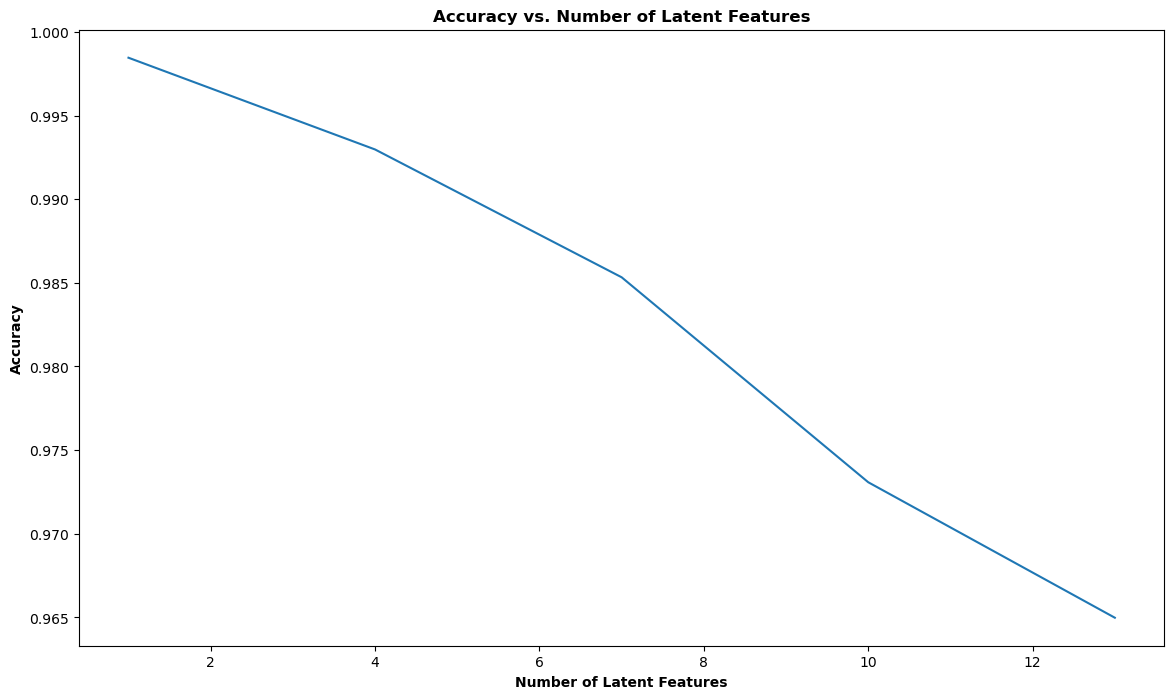

In [155]:
fig = plt.figure(figsize=(14, 8))    
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / (train_df.shape[0] * train_df.shape[1]))
plt.xlabel('Number of Latent Features', weight = 'bold');
plt.ylabel('Accuracy', weight = 'bold');
plt.title('Accuracy vs. Number of Latent Features', weight = 'bold');

In [132]:
def predict_offer(user_matrix, offer_matrix, customer_id, offer_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    movie_matrix - latent factor by movie matrix
    user_id - the user_id from the reviews df
    movie_id - the movie_id according the movies df
    
    OUTPUT:
    pred - the predicted rating for user_id-movie_id according to FunkSVD
    '''
    # Create series of users and movies in the right order
    customer_ids_series = np.array(train_data_df.index)
    offer_ids_series = np.array(train_data_df.columns)
    
    # User row and Movie Column
    customer_row = np.where(customer_ids_series == customer_id)[0][0]
    offer_col = np.where(offer_ids_series == offer_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[customer_row, :], offer_matrix[:, offer_col])
    
    return pred

In [133]:
# test prediction function
pred_val = predict_offer(user_mat, offer_mat, 2, 2)
pred_val

1.2902307490668283

In [134]:
# test prediction function
pred_val = predict_offer(user_mat, offer_mat, 122, 8)
pred_val

1.1934346008546743

In [136]:
def validation_comparison(val_df, num_preds):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    num_preds - (int) the number of rows (going in order) you would like to make predictions for
    
    OUTPUT:
    Nothing returned - print a statement about the prediciton made for each row of val_df from row 0 to num_preds
    '''
    val_customers = np.array(val_df['customer_id'])
    val_offers = np.array(val_df['offer_id'])
    val_ratings = np.array(val_df['offer_completed'])
    
    
    for idx in range(num_preds):
        try:
            pred = predict_offer(user_mat, offer_mat, val_customers[idx], val_offers[idx])
            print("The actual offer for customer_id {} on offer_id {} is {}.\n While the predicted offer is {}."
                  .format(val_customers[idx], val_offers[idx], val_ratings[idx], round(pred))) 
        except IndexError:
            continue

        
# Perform the predicted vs. actual for the first 10 rows.  How does it look?
validation_comparison(val_df, 8)

The actual offer for customer_id 1882 on offer_id 10 is 0.
 While the predicted offer is 5.
The actual offer for customer_id 4351 on offer_id 10 is 0.
 While the predicted offer is 4.
The actual offer for customer_id 1860 on offer_id 10 is 0.
 While the predicted offer is 5.
The actual offer for customer_id 11340 on offer_id 10 is 0.
 While the predicted offer is 4.
The actual offer for customer_id 6105 on offer_id 10 is 0.
 While the predicted offer is 3.
The actual offer for customer_id 14560 on offer_id 10 is 0.
 While the predicted offer is 4.
The actual offer for customer_id 15184 on offer_id 10 is 0.
 While the predicted offer is 5.
The actual offer for customer_id 4628 on offer_id 10 is 0.
 While the predicted offer is 4.
